# Extra Trees

In [7]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats import randint, uniform

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from utils import load_and_prepare_data, evaluate_metrics, plot_roc_curve, optimize_threshold

In [3]:
df = pd.read_parquet("../diabetes_dataset_prepared.parquet")
X_train, X_test, y_train, y_test = load_and_prepare_data(df)

Let's try a simple, untuned model first.

In [4]:
etc_untuned = ExtraTreesClassifier(random_state=2025)
etc_untuned.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [5]:
y_train_pred = etc_untuned.predict(X_train)
y_test_pred = etc_untuned.predict(X_test)

Training Set Metrics:


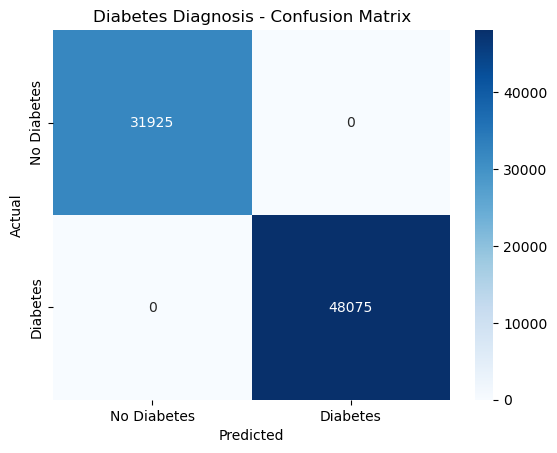

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Test Set Metrics:


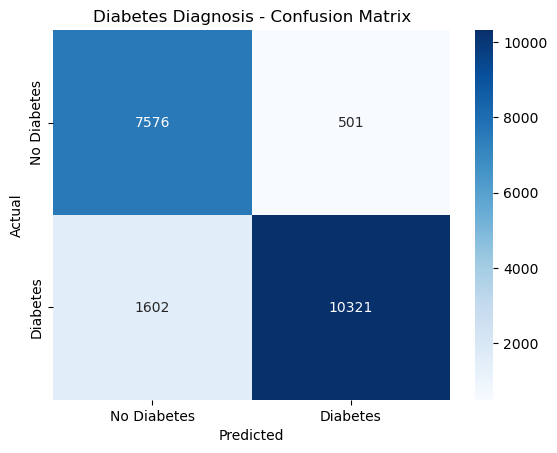

Accuracy: 0.89485
Precision: 0.953705414895583
Recall: 0.8656378428247924
F1 Score: 0.9075401187074082


In [6]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

This model actually performs a bit worse than some of the other ones we've tried so far, at least on the test set. Let us optimize the hyperparameters.

In [8]:
param_dist = {
    "n_estimators": randint(100, 400),
    "max_depth": randint(10, 50),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "max_features": uniform(0.3, 0.7),
    "bootstrap": [False, True],
    "criterion": ["gini", "entropy"]
}

search = RandomizedSearchCV(
    ExtraTreesClassifier(random_state=2025),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="f1",
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)

n_estimators = search.best_params_["n_estimators"]
max_depth = search.best_params_["max_depth"]
min_samples_split = search.best_params_["min_samples_split"]
min_samples_leaf = search.best_params_["min_samples_leaf"]
max_features = search.best_params_["max_features"]
bootstrap = search.best_params_["bootstrap"]
criterion = search.best_params_["criterion"]

search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 34,
 'max_features': np.float64(0.9908208556203622),
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 235}

In [9]:
etc = ExtraTreesClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    bootstrap=bootstrap,
    criterion=criterion,
    random_state=2025
)

etc.fit(X_train, y_train)

,n_estimators,235
,criterion,'gini'
,max_depth,34
,min_samples_split,2
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,np.float64(0.9908208556203622)
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [10]:
y_train_pred = etc.predict(X_train)
y_test_pred = etc.predict(X_test)

Training Set Metrics:


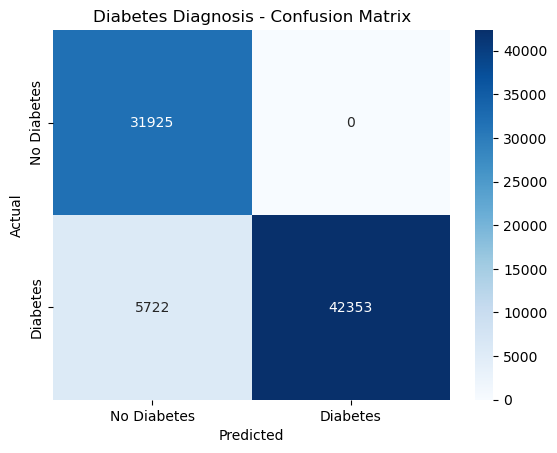

Accuracy: 0.928475
Precision: 1.0
Recall: 0.8809776391055643
F1 Score: 0.9367231388507984


Test Set Metrics:


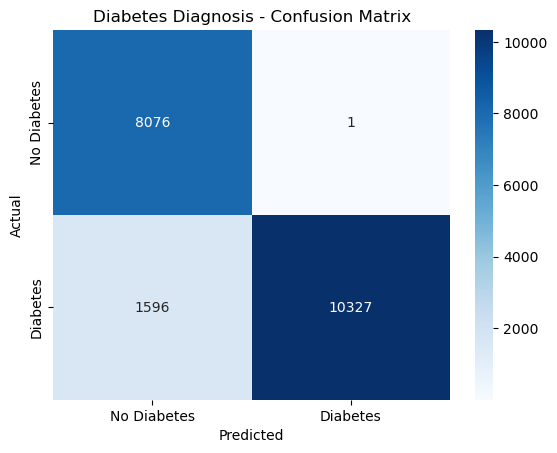

Accuracy: 0.92015
Precision: 0.9999031758326878
Recall: 0.866141071877883
F1 Score: 0.9282279448114692


In [11]:
evaluate_metrics(y_train, y_train_pred, "Training Set Metrics:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, y_test_pred, "Test Set Metrics:")

Not better than the other models.

In [12]:
y_train_probs = etc.predict_proba(X_train)[:, 1]
y_test_probs = etc.predict_proba(X_test)[:, 1]

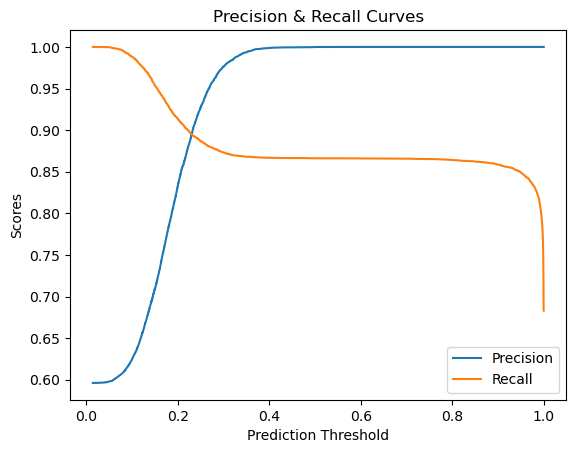

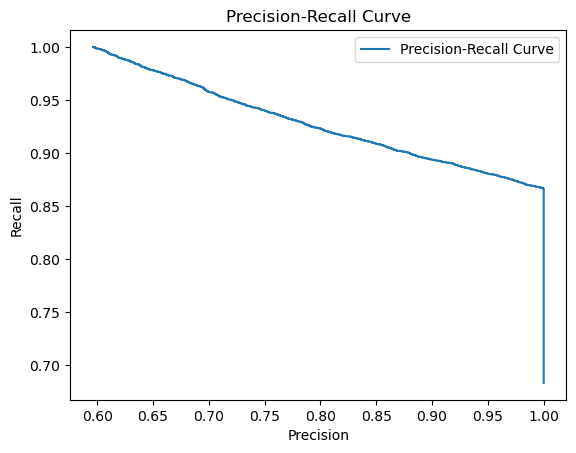

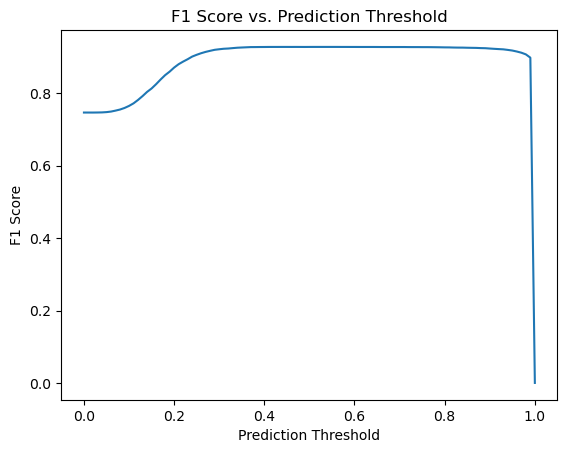

np.float64(0.51)

In [13]:
thresh = optimize_threshold(y_test, y_test_probs)
thresh

In [14]:
preds_train = y_train_probs >= thresh
preds_test = y_test_probs >= thresh

Training Set Metrics with Optimized Threshold:


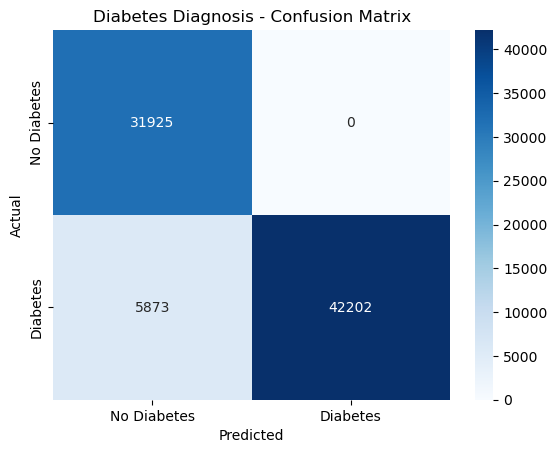

Accuracy: 0.9265875
Precision: 1.0
Recall: 0.8778367134685388
F1 Score: 0.934944670292544


Test Set Metrics with Optimized Threshold:


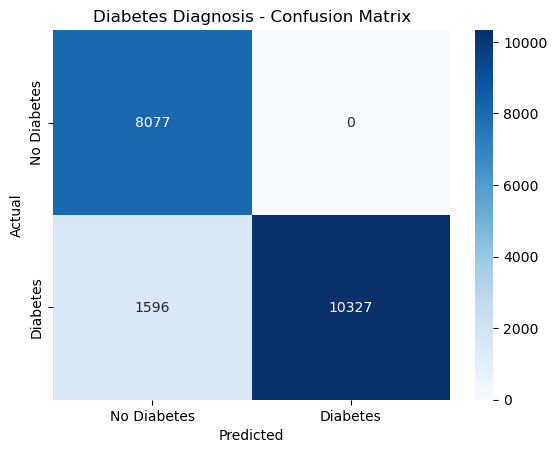

Accuracy: 0.9202
Precision: 1.0
Recall: 0.866141071877883
F1 Score: 0.9282696629213483


In [15]:
evaluate_metrics(y_train, preds_train, "Training Set Metrics with Optimized Threshold:")

print("\n" + "="*75 + "\n")

evaluate_metrics(y_test, preds_test, "Test Set Metrics with Optimized Threshold:")

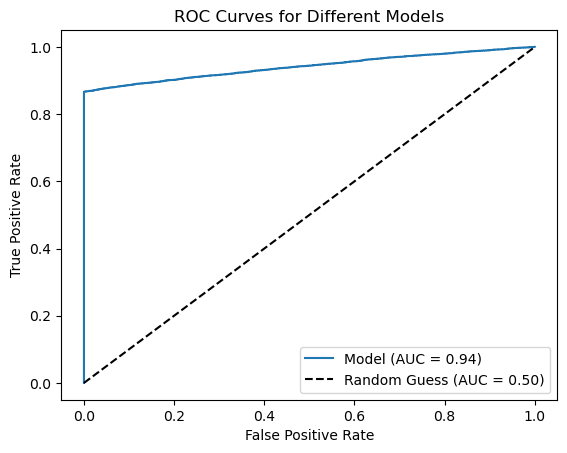

In [16]:
plot_roc_curve(y_test, y_test_probs)

This model looks the same as many of the other ones we've tried.

In [17]:
joblib.dump(etc, "../models/extra_trees_model.joblib")

['../models/extra_trees_model.joblib']

The model size is too large for GitHub. We will compress it.

In [2]:
import joblib

model = joblib.load("../models/extra_trees_model.joblib")

joblib.dump(model, "../models/extra_trees_model.joblib", compress=3)

['../models/extra_trees_model.joblib']